<a href="https://colab.research.google.com/github/Adda2003/STOCK_PRICE_PREDICTION/blob/main/TemporalFusionTransformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch -f https://download.pytorch.org/whl/torch_stable.html
!pip install pytorch-lightning
!pip install pytorch-forecasting
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
import pytorch_forecasting
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import warnings

warnings.filterwarnings("ignore")  # avoid printing out absolute paths

os.chdir("../../..")
import copy
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
!pip install yfinance
import numpy as np
import pandas as pd
import os, datetime
import matplotlib.pyplot as plt
import pandas_datareader as pdr
import yfinance as yf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Set the start and end date
start_date = '1971-01-01'
end_date = '2022-12-31'
 
# Set the ticker
ticker = 'GOOGL'
 
# Get the data
data = yf.download(ticker, start_date, end_date)
 
# Print the last 5 rows
print(data.tail())

[*********************100%***********************]  1 of 1 completed
                 Open       High        Low      Close  Adj Close    Volume
Date                                                                       
2022-12-19  90.260002  90.559998  88.209999  88.440002  88.440002  29493000
2022-12-20  88.110001  89.180000  87.440002  89.019997  89.019997  23453800
2022-12-21  89.080002  90.220001  88.320000  89.580002  89.580002  24745600
2022-12-22  88.160004  88.540001  86.320000  87.760002  87.760002  27642300
2022-12-23  87.110001  89.529999  87.080002  89.389999  89.389999  13148396


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4621 entries, 2004-08-19 to 2022-12-23
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       4621 non-null   float64
 1   High       4621 non-null   float64
 2   Low        4621 non-null   float64
 3   Close      4621 non-null   float64
 4   Adj Close  4621 non-null   float64
 5   Volume     4621 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 252.7 KB


In [ ]:
data.sort_values('Date', inplace=True)
data['Volume'].replace(to_replace=0, method='ffill', inplace=True)

In [ ]:
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2004-08-19,2.502503,2.604104,2.401401,2.511011,2.511011,893181924
2004-08-20,2.527778,2.729730,2.515015,2.710460,2.710460,456686856
2004-08-23,2.771522,2.839840,2.728979,2.737738,2.737738,365122512
2004-08-24,2.783784,2.792793,2.591842,2.624374,2.624374,304946748
2004-08-25,2.626627,2.702703,2.599600,2.652653,2.652653,183772044
...,...,...,...,...,...,...
2022-12-19,90.260002,90.559998,88.209999,88.440002,88.440002,29493000
2022-12-20,88.110001,89.180000,87.440002,89.019997,89.019997,23453800
2022-12-21,89.080002,90.220001,88.320000,89.580002,89.580002,24745600


In [ ]:
data[data.columns[0:0]]

""
Date
2004-08-19
2004-08-20
2004-08-23
2004-08-24
2004-08-25
...
2022-12-19
2022-12-20
2022-12-21


In [ ]:
data.to_csv ('google.csv')

In [ ]:
data = data.reset_index()

In [ ]:
data


,Date,Open,High,Low,Close,Adj Close,Volume
0,2004-08-19,2.502503,2.604104,2.401401,2.511011,2.511011,893181924
1,2004-08-20,2.527778,2.729730,2.515015,2.710460,2.710460,456686856
2,2004-08-23,2.771522,2.839840,2.728979,2.737738,2.737738,365122512
3,2004-08-24,2.783784,2.792793,2.591842,2.624374,2.624374,304946748
4,2004-08-25,2.626627,2.702703,2.599600,2.652653,2.652653,183772044
...,...,...,...,...,...,...,...
4616,2022-12-19,90.260002,90.559998,88.209999,88.440002,88.440002,29493000
4617,2022-12-20,88.110001,89.180000,87.440002,89.019997,89.019997,23453800
4618,2022-12-21,89.080002,90.220001,88.320000,89.580002,89.580002,24745600
4619,2022-12-22,88.160004,88.540001,86.320000,87.760002,87.760002,27642300


In [ ]:
data['Date']

0      2004-08-19
1      2004-08-20
2      2004-08-23
3      2004-08-24
4      2004-08-25
          ...    
4616   2022-12-19
4617   2022-12-20
4618   2022-12-21
4619   2022-12-22
4620   2022-12-23
Name: Date, Length: 4621, dtype: datetime64[ns]

In [ ]:
data.drop(data.tail(1).index,
        inplace = True)

In [ ]:
data["time_idx"] = data["Date"].dt.year * 365 + data["Date"].dt.month *30 + data["Date"].dt.day
data["time_idx"] -= data["time_idx"].min()
data['group']= np.repeat(np.arange(10),154*3)

In [ ]:
data

,Date,Open,High,Low,Close,Adj Close,Volume,time_idx,group
0,2004-08-19,2.502503,2.604104,2.401401,2.511011,2.511011,893181924,0,0
1,2004-08-20,2.527778,2.729730,2.515015,2.710460,2.710460,456686856,1,0
2,2004-08-23,2.771522,2.839840,2.728979,2.737738,2.737738,365122512,4,0
3,2004-08-24,2.783784,2.792793,2.591842,2.624374,2.624374,304946748,5,0
4,2004-08-25,2.626627,2.702703,2.599600,2.652653,2.652653,183772044,6,0
...,...,...,...,...,...,...,...,...,...
4615,2022-12-16,90.760002,91.330002,89.519997,90.260002,90.260002,58000200,6687,9
4616,2022-12-19,90.260002,90.559998,88.209999,88.440002,88.440002,29493000,6690,9
4617,2022-12-20,88.110001,89.180000,87.440002,89.019997,89.019997,23453800,6691,9
4618,2022-12-21,89.080002,90.220001,88.320000,89.580002,89.580002,24745600,6692,9


In [ ]:
data['time_idx']

0          0
1          1
2          4
3          5
4          6
        ... 
4615    6687
4616    6690
4617    6691
4618    6692
4619    6693
Name: time_idx, Length: 4620, dtype: int64

In [ ]:
max_prediction_length = 154
max_encoder_length = 154*2
training_cutoff = data["time_idx"].max() - max_prediction_length

training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="Close",
    group_ids=['group'],
    min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    # static_categoricals=["agency", "sku"],
    # static_reals=["avg_population_2017", "avg_yearly_household_income_2017"],
    # time_varying_known_categoricals=["special_days", "month"],
    # variable_groups={"special_days": special_days},  # group of categorical variables can be treated as one variable
    time_varying_known_reals=["time_idx"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[
        "Open",
        "Close",
        "High",
        "Low",
        "Adj Close",
        "Volume",
        
    ],
    # target_normalizer=GroupNormalizer(
    #     groups=["agency", "sku"], transformation="softplus"
    # ),  # use softplus and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    allow_missing_timesteps= True,
)

# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(training, data, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

In [ ]:
# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    gpus=0,
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=16,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

INFO:lightning_lite.utilities.seed:Global seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Number of parameters in network: 22.2k


In [ ]:
import pytorch_forecasting.models

In [ ]:
import pytorch_forecasting.models.temporal_fusion_transformer

In [ ]:
!pip install pytorch_forecasting.models.temporal_fusion_transformer.tuning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement pytorch_forecasting.models.temporal_fusion_transformer.tuning (from versions: none)
ERROR: No matching distribution found for pytorch_forecasting.models.temporal_fusion_transformer.tuning


In [ ]:
!pip install pytorch-forecasting[mqf2]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 42 kB 1.6 MB/s 
     |████████████████████████████████| 829 kB 58.4 MB/s 
     |████████████████████████████████| 97 kB 8.0 MB/s 
  Created wheel for cpflows: filename=cpflows-0.1.2-py3-none-any.whl size=54321 sha256=15b9dcc8f531b02fca76b37bb6f2dd07f112270dc87e514d62a727d634532473
  Stored in directory: /root/.cache/pip/wheels/ff/dd/62/02d4135f6fec0d934facf3a74e17dd1c8403c4ff0dbf466c20
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491071 sha256=16b68d383415f032314d31ffeb4b5f75262e9017cdc002df81ef3a328c65d047
  Stored in directory: /root/.cache/pip/wheels/8e/70/28/3d6ccd6e315f65f245da085482a2e1c7d14b90b30f239e2cf4
  Created wheel for subprocess32: filename=subprocess32-3.5.4-py3-none-any.whl size=6501 sha256=4b402208a177ec268c392bf18de07879bd0677ef4af8554cf1e4b4ab93f48482
  Stored in directory: /root/.cache/pip/wheels/9f/69

In [ ]:
import  scipy.signal.signaltools

def _centered(arr, newsize):
    # Return the center newsize portion of the array.
    newsize = np.asarray(newsize)
    currsize = np.array(arr.shape)
    startind = (currsize - newsize) // 2
    endind = startind + newsize
    myslice = [slice(startind[k], endind[k]) for k in range(len(endind))]
    return arr[tuple(myslice)]

scipy.signal.signaltools._centered = _centered

In [ ]:
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

In [ ]:
pip install statsmodels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install scipy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from pytorch_lightning import loggers 


In [ ]:
actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
(actuals - baseline_predictions).abs().mean().item()

4.318411827087402

In [ ]:
res = trainer.tuner.lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
    # early_stop_threshold=1000.0,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /.lr_find_a7d591e6-4846-4454-8780-66531fcbcbab.ckpt


KeyError: ignored

In [ ]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=30,
    gpus=0,
    enable_model_summary=True,
    gradient_clip_val=0.1,
    limit_train_batches=30,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
    
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.1288249551693133,
    hidden_size=16,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Number of parameters in network: 22.2k


In [ ]:
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

INFO:pytorch_lightning.callbacks.model_summary:
   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 176   
4  | static_variable_selection          | VariableSelectionNetwork        | 1.7 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 5.1 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.2 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


In [ ]:
pip install pytorch-forecasting

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pytorch_forecasting.models
import pytorch_forecasting.models.temporal_fusion_transformer
import pytorch_forecasting.models.temporal_fusion_transformer.tuning
!pip install pytorch-forecasting[mqf2]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

In [ ]:
import pickle

from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

# create study
study = optimize_hyperparameters(
    train_dataloader,
    val_dataloader,
    model_path="optuna_test",
    n_trials=5,
    max_epochs=50,
    gradient_clip_val_range=(0.01, 1.0),
    hidden_size_range=(8, 128),
    hidden_continuous_size_range=(8, 128),
    attention_head_size_range=(1, 4),
    learning_rate_range=(0.001, 0.1),
    dropout_range=(0.1, 0.3),
    trainer_kwargs=dict(limit_train_batches=30),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
)

# save study results - also we can resume tuning at a later point in time
with open("test_study.pkl", "wb") as fout:
    pickle.dump(study, fout)

# show best hyperparameters
print(study.best_trial.params)

[I 2022-12-23 18:52:03,985] A new study created in memory with name: no-name-836970f4-f867-42ac-a8ee-d89a5badfeb9
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.
[I 2022-12-23 19:06:36,129] Trial 0 finished with value: 2.572509765625 and parameters: {'gradient_clip_val': 0.023156638689460555, 'hidden_size': 13, 'dropout': 0.23939204292680383, 'hidden_continuous_size': 12, 'attention_head_size': 3, 'learning_rate': 0.08650308219539153}. Best is trial 0 with value: 2.572509765625.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cu

{'gradient_clip_val': 0.023156638689460555, 'hidden_size': 13, 'dropout': 0.23939204292680383, 'hidden_continuous_size': 12, 'attention_head_size': 3, 'learning_rate': 0.08650308219539153}


In [ ]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [ ]:
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)
(actuals - predictions).abs().mean()

tensor(2.0198)

In [ ]:
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)

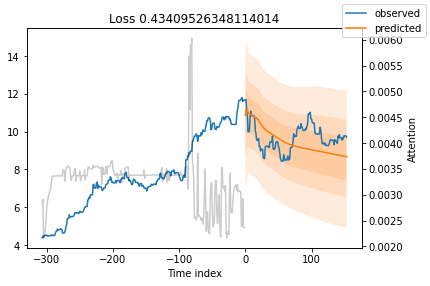

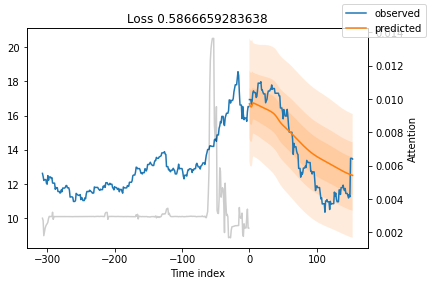

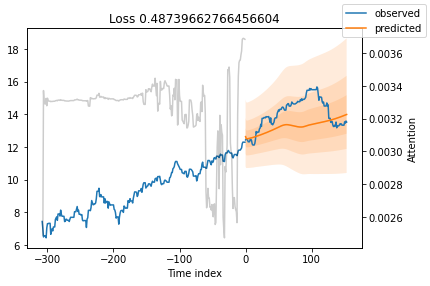

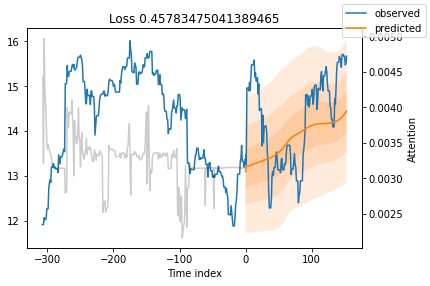

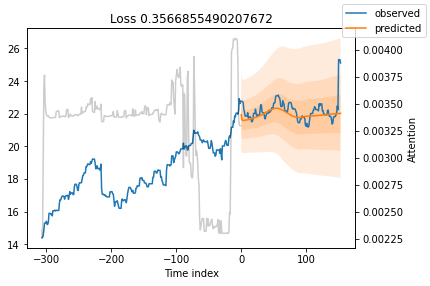

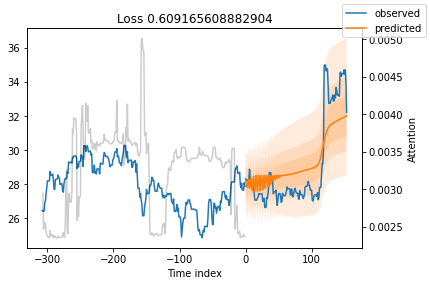

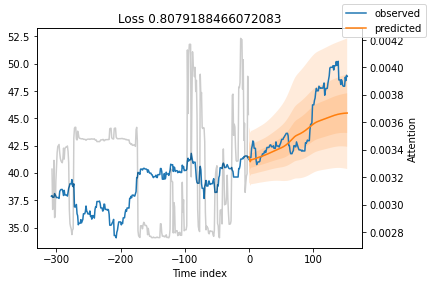

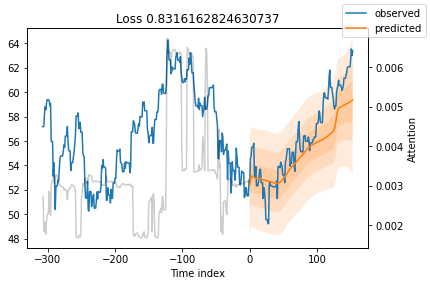

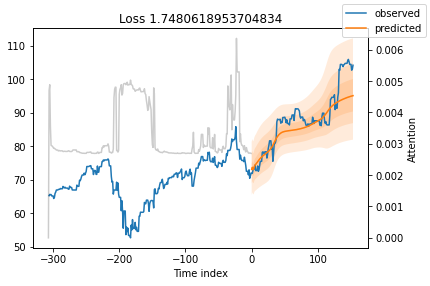

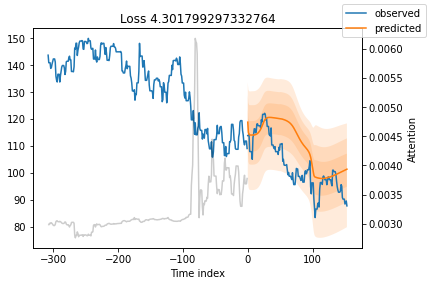

In [ ]:
for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);

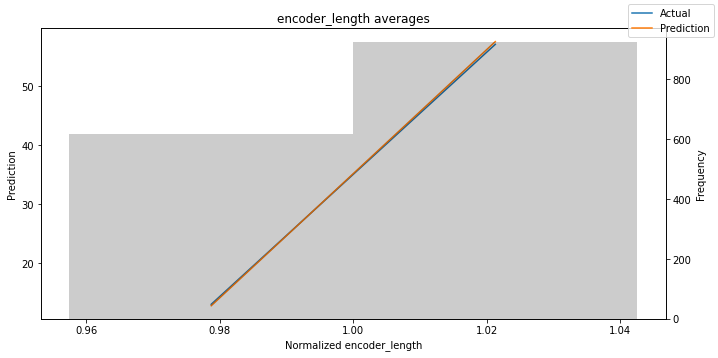

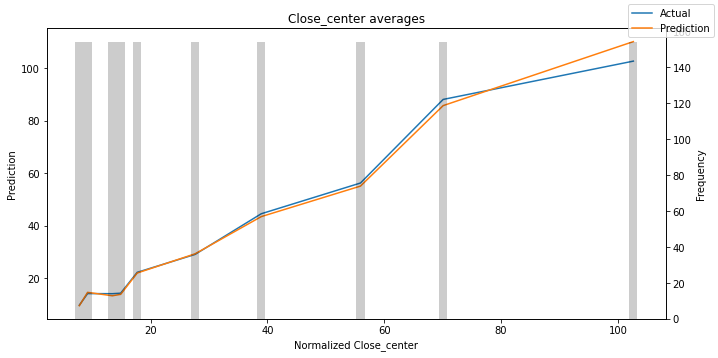

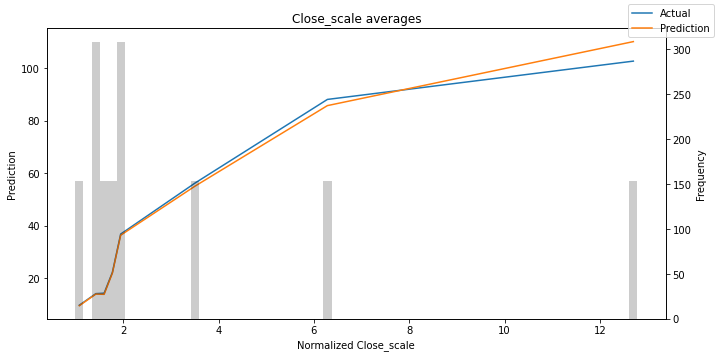

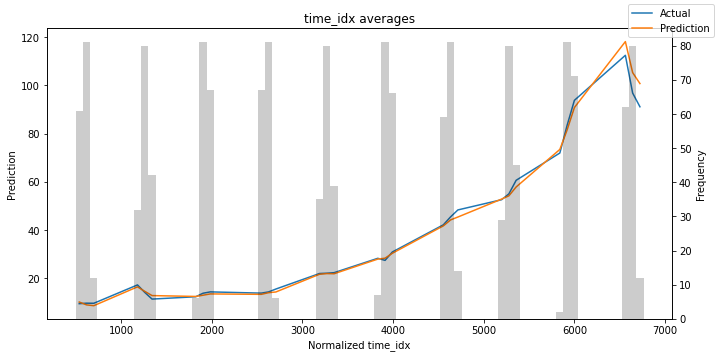

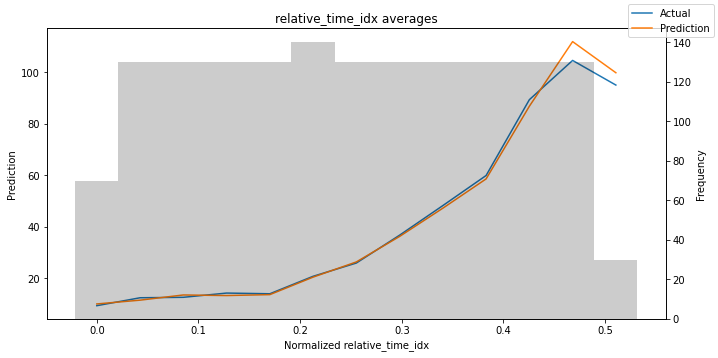

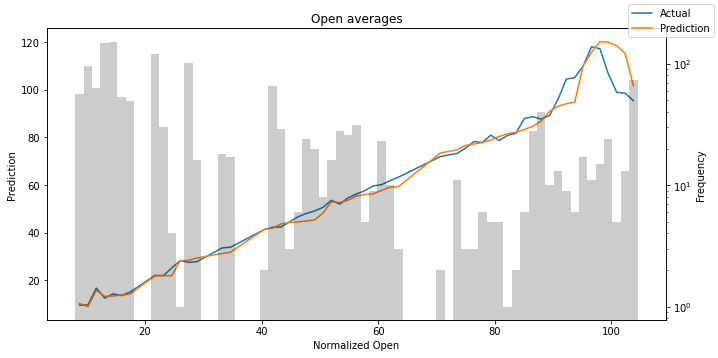

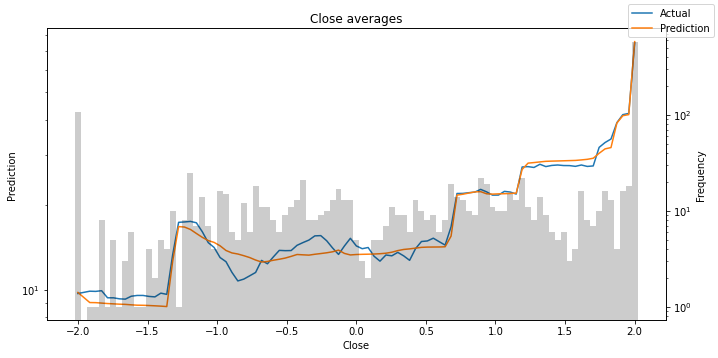

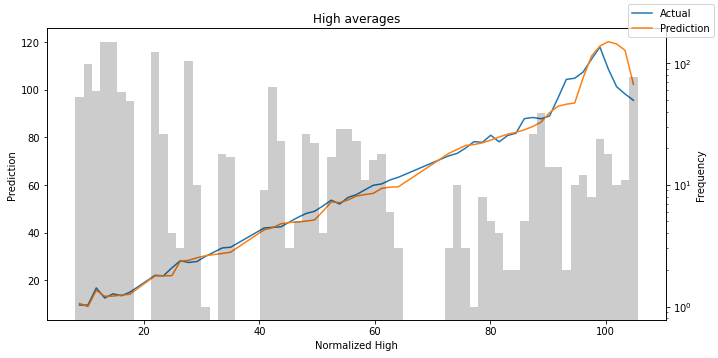

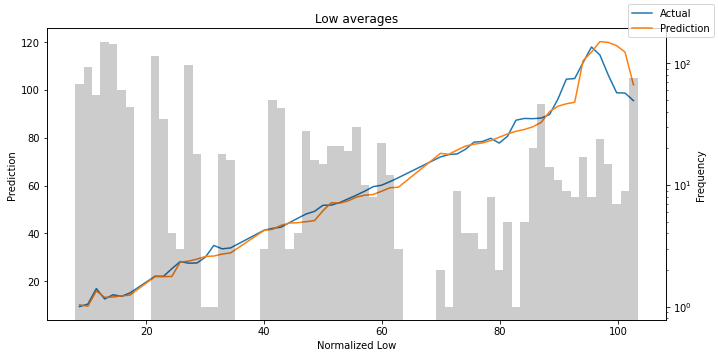

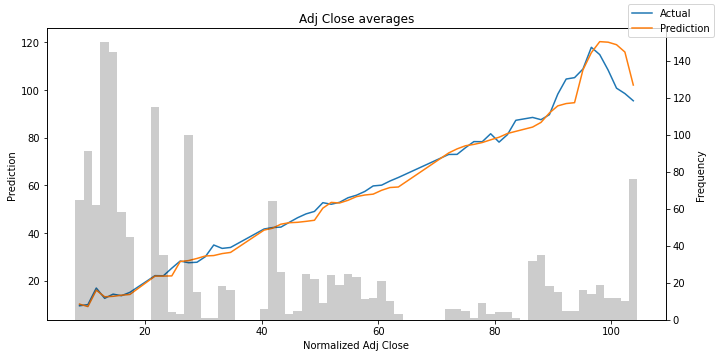

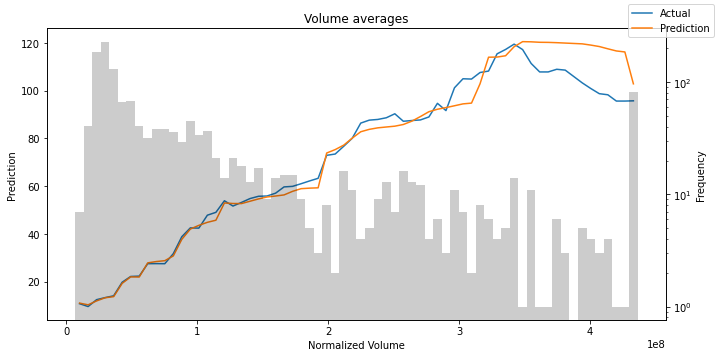

In [ ]:
predictions, x = best_tft.predict(val_dataloader, return_x=True)
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(x, predictions)
best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals);


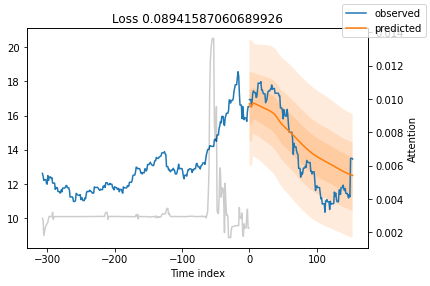

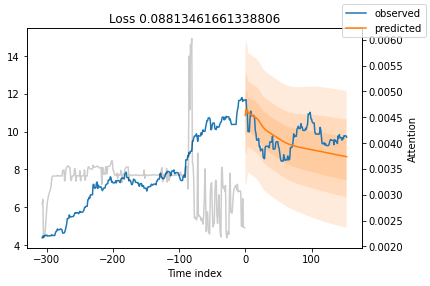

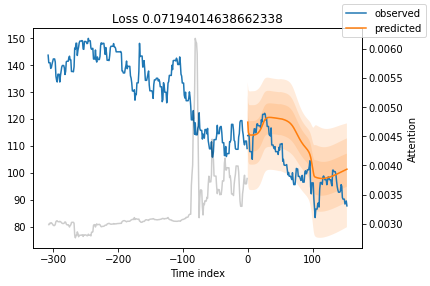

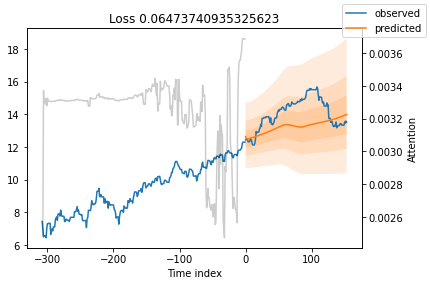

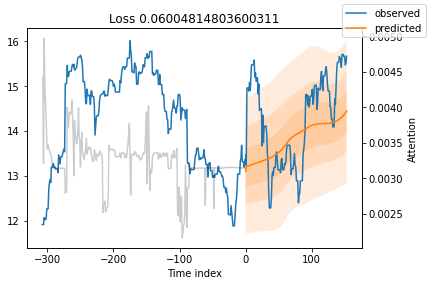

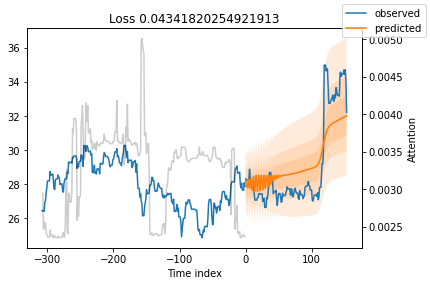

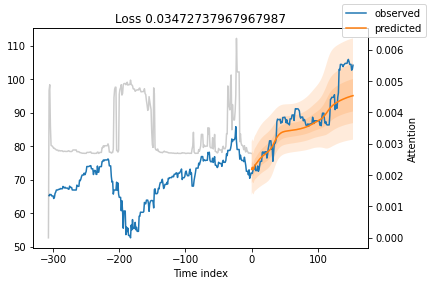

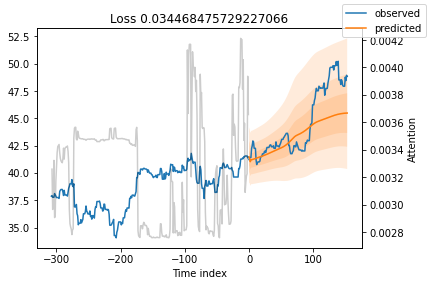

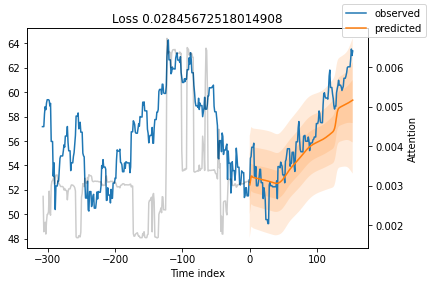

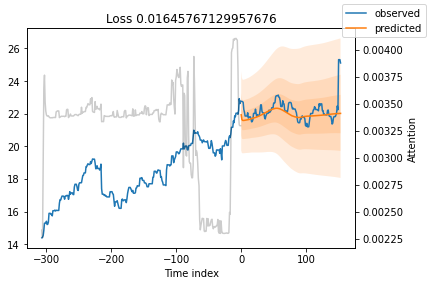

In [ ]:
predictions = best_tft.predict(val_dataloader)
mean_losses = SMAPE(reduction="none")(predictions, actuals).mean(1)
indices = mean_losses.argsort(descending=True)  # sort losses
for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(
        x, raw_predictions, idx=indices[idx], add_loss_to_title=SMAPE(quantiles=best_tft.loss.quantiles)
    );

{'attention': <Figure size 432x288 with 1 Axes>,
 'static_variables': <Figure size 504x198 with 1 Axes>,
 'encoder_variables': <Figure size 504x288 with 1 Axes>,
 'decoder_variables': <Figure size 504x180 with 1 Axes>}

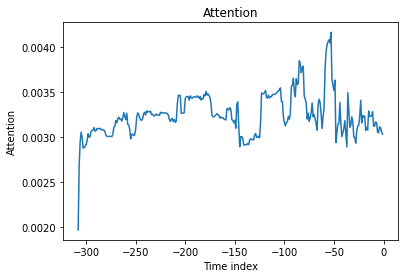

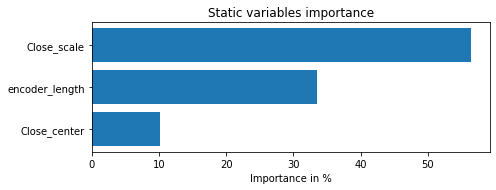

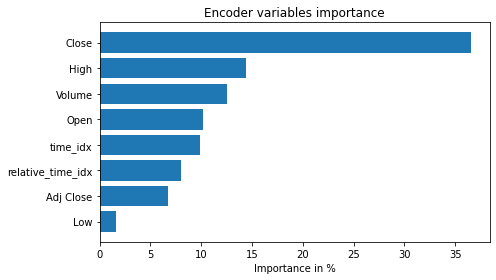

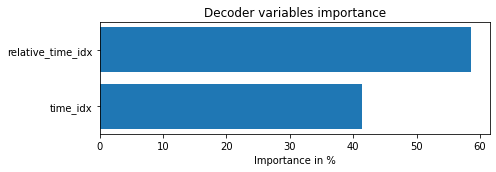

In [ ]:
interpretation = best_tft.interpret_output(raw_predictions, reduction="sum")
best_tft.plot_interpretation(interpretation)